### ライブラリとデータの挿入と整理

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
original = pd.read_csv("data.csv", header=0)

In [117]:
fa_data = original.iloc[:,7:29]
aov_data = original.iloc[:, 29:]

### 因子分析

In [87]:
for i in range(len(fa_data.columns)):
    if "ない" in fa_data.columns[i]:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "2")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "6")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "2")
        
    fa_data = fa_data.rename({str(fa_data.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].astype(int)

In [89]:
fa_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
mean,6.125,4.625,5.875,5.25,5.625,4.375,4.5,6.25,5.875,3.25,...,3.125,5.125,5,6.5,6,3.5,3.75,3.875,2.875,4
std,0.991031,1.30247,1.72689,1.48805,0.916125,2.19984,1.85164,0.707107,0.991031,1.83225,...,1.80772,1.45774,2.26779,0.534522,1.30931,1.77281,2.31455,2.16712,1.95941,1.06904
min,4,3,2,3,4,1,2,5,4,1,...,1,3,1,6,3,1,1,1,1,2
25%,6,3.75,5.75,4,5,2.75,3.5,6,5.75,2,...,1.75,4.5,4.25,6,6,2,2,2.5,1,4
50%,6,4.5,6.5,5.5,6,5,4.5,6,6,3,...,3,5.5,6,6.5,6,3.5,3,4,2.5,4
75%,7,6,7,6.25,6,6,6,7,6.25,3.75,...,4.25,6,6.25,7,7,5,6,6,4.25,4
max,7,6,7,7,7,7,7,7,7,6,...,6,7,7,7,7,6,7,6,6,6


In [ ]:
from pandas import plotting

# plotting.scatter_matrix(fa_data, figsize=(22, 22), alpha=0.8)

In [108]:
# 標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(fa_data)

z = sc.transform(fa_data)

print(z)
print(z.shape)

[[-0.13483997  1.12857619  0.69644091  1.25723711  1.60451491  1.27565915
   1.44337567  1.13389342  1.21355975  1.60451491  1.34164079  0.76249285
  -1.25667616  1.37504775  0.94280904  1.          0.81649658 -1.50755672
   1.5011107  -1.41824076 -1.02299151  0.        ]
 [-2.29227953 -0.51298918  0.69644091 -0.1796053  -1.89624489 -0.18223702
  -0.28867513  1.13389342 -0.94387981 -0.72932496  0.89442719  1.37248713
   0.51745489  0.64168895  0.          1.          0.81649658  0.30151134
   0.11547005  1.04826491  0.61379491  0.        ]
 [ 0.94387981 -1.33377186  0.07738232 -0.89802651  0.43759497 -1.6401332
  -1.44337567 -0.37796447  0.13483997 -0.72932496 -1.34164079 -1.06748999
  -1.25667616 -1.55838744 -1.88561808 -1.          0.81649658  0.90453403
  -0.80829038 -0.43163849 -1.02299151  0.        ]
 [-0.13483997 -1.33377186 -2.39885202  0.53881591 -0.72932496 -0.66820241
   0.28867513 -1.88982237  0.13483997 -1.31278492 -0.89442719 -0.45749571
  -0.66529914 -0.09166985  0.47140

In [109]:
# 主成分分析
from sklearn.decomposition import PCA

pca = PCA() 
pca.fit(z)  


PCA()

In [ ]:
# 固有値を取得
ev = pca.explained_variance_

pd.DataFrame(ev, 
             index=["PC{}".format(x + 1) for x in range(len(fa_data.columns))], 
             columns=["固有値"])


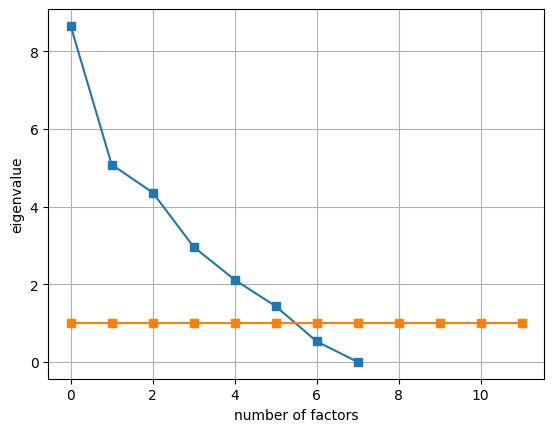

In [103]:
# 因子数の決定
ev = pca.explained_variance_

ev_1 = np.ones(12)

plt.plot(ev, 's-')   
plt.plot(ev_1, 's-') 

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()


In [106]:
# 寄与率の取得
evr = pca.explained_variance_ratio_

pd.DataFrame(evr, 
             columns=["寄与率"])

,寄与率
0,3.442261e-01
1,2.021204e-01
2,1.735413e-01
3,1.178089e-01
4,8.415601e-02
5,5.710593e-02
6,2.104152e-02
7,5.453092e-33


In [111]:
from sklearn.decomposition import FactorAnalysis as FA

n_components=5

fa = FA(n_components, max_iter=5000)
fitted = fa.fit_transform(z)

print(fitted)
print(fitted.shape)


[[ 1.72892902  0.99867042  0.27346886 -1.19410826  1.22662901]
 [-1.08897041 -1.25114182 -1.18368726 -0.46903143  1.51546982]
 [-0.53136955  1.52583495 -0.43772318  1.31899019  0.06806163]
 [-1.09620604 -0.22734684  2.05896072 -0.9390814  -0.47099112]
 [ 0.03704922  0.31259185  0.17020415  0.88242047 -0.3866064 ]
 [ 1.32103565 -1.32604084 -0.56400311  0.02525396 -1.46137696]
 [-0.69761917  0.75792871 -1.07847085 -1.01124449 -1.12703925]
 [ 0.32715127 -0.79049642  0.76125068  1.38680096  0.63585327]]
(8, 5)


In [112]:
fa.components_.T

array([[ 2.71132407e-01,  4.78710762e-01,  3.85791478e-01,
         6.10322728e-01, -3.65905947e-01],
       [ 6.53478016e-01, -1.28021248e-02, -4.29786807e-01,
        -3.95790221e-01, -2.77758122e-01],
       [ 4.68605402e-01,  3.35810963e-02, -7.97123897e-01,
         1.24899666e-01,  1.65770477e-01],
       [ 2.17104122e-01,  5.38176818e-02, -6.99546647e-02,
        -8.79631788e-01, -1.49421791e-01],
       [ 8.31531833e-01,  4.33273317e-01,  2.42187450e-01,
         2.47136211e-01, -3.00890673e-02],
       [ 7.67996158e-01, -3.93504095e-01,  1.80199642e-01,
         6.81920882e-04,  2.29406741e-01],
       [ 7.10496791e-01, -4.35317585e-01,  4.55114426e-01,
        -1.66911077e-01,  2.65278287e-01],
       [ 1.96266649e-01,  1.38486967e-01, -7.64933946e-01,
        -3.27941400e-01,  3.94226527e-01],
       [ 1.97672396e-01,  6.18744738e-01, -1.54232130e-01,
        -6.08117927e-01, -3.62394101e-01],
       [ 9.45398129e-01, -5.84999347e-02, -2.45644945e-01,
        -1.80752896e-01

In [114]:
Factor_loading_matrix = fa.components_.T

pd.DataFrame(Factor_loading_matrix, 
             columns=["first", "second", "third", "fourth", "fifth"], 
             index=[fa_data.columns])


,first,second,third,fourth,fifth
X1,0.271132,0.478711,0.385791,0.610323,-0.365906
X2,0.653478,-0.012802,-0.429787,-0.395790,-0.277758
X3,0.468605,0.033581,-0.797124,0.124900,0.165770
X4,0.217104,0.053818,-0.069955,-0.879632,-0.149422
X5,0.831532,0.433273,0.242187,0.247136,-0.030089
X6,0.767996,-0.393504,0.180200,0.000682,0.229407
X7,0.710497,-0.435318,0.455114,-0.166911,0.265278
X8,0.196267,0.138487,-0.764934,-0.327941,0.394227
X9,0.197672,0.618745,-0.154232,-0.608118,-0.362394
X10,0.945398,-0.058500,-0.245645,-0.180753,-0.098152


### 定量的分析

In [123]:
# t-test
from scipy.stats import ttest_ind

human = aov_data[aov_data["店員"] == "人"]
robot = aov_data[aov_data["店員"] == "ロボット"]

stat, p = ttest_ind(human["金額"], robot["金額"])

print("T=%f, p-value = %f"%(stat,p))

T=1.095796, p-value = 0.315192


In [124]:
#一要因分散分析
from scipy.stats import f_oneway

f, p = f_oneway(human["金額"], robot["金額"])
print("F=%f, p-value = %f"%(f,p))

F=1.200769, p-value = 0.315192
